In [275]:
import os
import pandas as pd
import numpy as np
import math
df = pd.read_csv(os.path.expanduser('data/DataSample.csv'))
poi = pd.read_csv(os.path.expanduser('data/POIList.csv'))

In [276]:
df = df.drop_duplicates(subset=[' TimeSt', 'Longitude', 'Latitude']) # drop records that are the same if they're from these three subsets

# Let's rename some of these to take out spaces, and cut down on typing throughout
df = df.rename(columns = {' TimeSt': 'TimeSt','Latitude':'lat', 'Longitude':'lon'})
poi=poi.rename(columns = {' Latitude':'lat', 'Longitude':'lon'})
poi.duplicated(subset=['lon', 'lat'])

0    False
1     True
2    False
3    False
dtype: bool

In [277]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [278]:
# %%timeit
from sklearn.neighbors import BallTree

bt = BallTree(np.deg2rad(poi[['lat', 'lon']].values), metric='haversine')
distances, indices = bt.query(np.deg2rad(np.c_[df['lat'], df['lon']]))


df['POI'] = indices+1
df['distance(km)'] = distances *6371

In [279]:
df['POI'] = 'POI' + df['POI'].astype(str)

In [280]:
df = df[df['distance(km)'] < (haversine(poi['lon'].max(),poi['lat'].max(),poi['lon'].min(), poi['lat'].min())/2)]

In [281]:
poi_users = df.groupby('POI')['distance(km)'].count()
poi_mean = df.groupby('POI')['distance(km)'].mean()
poi_std = df.groupby('POI')['distance(km)'].std()

In [282]:
print("The number of users for each poi is:", poi_users, "The mean distance for each of the POI's to their respective users is:", poi_mean, "The standard deviation for each of the groups is:", poi_std)

The number of users for each poi is: POI
POI1    9720
POI3    9795
POI4     462
Name: distance(km), dtype: int64 The mean distance for each of the POI's to their respective users is: POI
POI1    293.910798
POI3    451.527555
POI4    238.335736
Name: distance(km), dtype: float64 The standard deviation for each of the groups is: POI
POI1    285.183540
POI3    223.350558
POI4    224.715608
Name: distance(km), dtype: float64


In [283]:
print("Note that these POIID's reference the same longitude / latitude. If we had more information about them, like what class of store they represent,\nwe could include them as separate points in an analysis.\nAs is, they can be thought of as having the same density / radii / popularity for now: \n \n", pd.concat(g for _, g in poi.groupby(["lat", "lon"]) if len(g) > 1))

Note that these POIID's reference the same longitude / latitude. If we had more information about them, like what class of store they represent,
we could include them as separate points in an analysis.
As is, they can be thought of as having the same density / radii / popularity for now: 
 
   POIID        lat         lon
0  POI1  53.546167 -113.485734
1  POI2  53.546167 -113.485734


In [284]:
df.groupby('POI')['distance(km)'].max()

POI
POI1    1684.757584
POI3    1474.580962
POI4     855.256289
Name: distance(km), dtype: float64

In [285]:
poi['radius'] = round(df.groupby('POI')['distance(km)'].max(), 3)

In [286]:
poi['radius'][0] = 1684.757584
poi['radius'][1] = 1684.757584
poi['radius'][2] = 1474.580962
poi['radius'][3] = 855.256289

<ipython-input-286-4aa98f697a64>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poi['radius'][0] = 1684.757584
<ipython-input-286-4aa98f697a64>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poi['radius'][1] = 1684.757584
<ipython-input-286-4aa98f697a64>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poi['radius'][2] = 1474.580962
<ipython-input-286-4aa98f697a64>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [287]:
poi

,POIID,lat,lon,radius
0,POI1,53.546167,-113.485734,1684.757584
1,POI2,53.546167,-113.485734,1684.757584
2,POI3,45.521629,-73.566024,1474.580962
3,POI4,45.224830,-63.232729,855.256289


In [288]:
g_test = df.copy()

### I've downloaded the census subdivision polygons, as well as their populations, so we'll need to match the projection used 
### in this geopandas dataframe to the crs used in the StatsCan Data i.e. 'EPSG:4269'

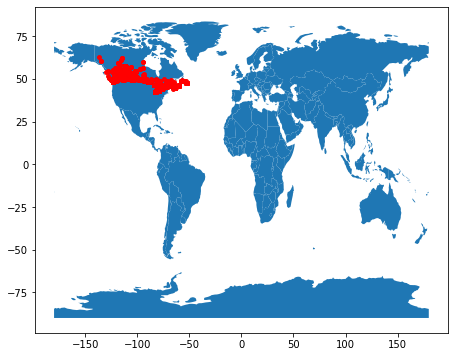

In [289]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame


geometry = [Point(xy) for xy in zip(g_test['lon'], g_test['lat'])]
gdf = GeoDataFrame(g_test, geometry=geometry).set_crs('EPSG:4269')

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [290]:
population = pd.read_csv(os.path.expanduser('T301EN.csv'))

In [291]:
population  = population[['Geographic code','Population, 2016' ]]

In [292]:
population[['Geographic code','Population, 2016' ]]

,Geographic code,"Population, 2016"
0,1001101,36.0
1,1001105,150.0
2,1001113,481.0
3,1001120,66.0
4,1001124,1625.0
...,...,...
5173,E = The 2011 Census was not completed during t...,NaN
5174,"For further information, refer to: http://www1...",NaN
5175,"Source: Statistics Canada, 2016 Census of Popu...",NaN
5176,How to cite: Statistics Canada. 2017. Populati...,NaN


In [293]:
# Read the data.
polygons = gpd.GeoDataFrame.from_file('data/gcsd000a11a_e.shp')

In [294]:
population = population.dropna()

In [295]:
population = population.rename(columns = {'Geographic code': 'CSDUID'})

In [296]:
import pandas as pd 

polygons = pd.merge(polygons, population, on = 'CSDUID')


In [297]:
polygons.head()

,CSDUID,CSDNAME,CSDTYPE,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CMAUID,CMANAME,CMATYPE,CMAPUID,SACTYPE,SACCODE,ERUID,ERNAME,CCSUID,CCSNAME,geometry,"Population, 2016"
0,4614042,Teulon,T,46,Manitoba,4614,Division No. 14,CDR,None,None,None,None,5,997,4660,Interlake,4614036,Rockwood,"POLYGON ((-97.27000 50.39072, -97.27000 50.393...",1201.0
1,1311006,Woodstock,TV,13,New Brunswick / Nouveau-Brunswick,1311,Carleton,CT,None,None,None,None,6,998,1350,Edmundston--Woodstock,1311004,Woodstock,"POLYGON ((-67.57382 46.17188, -67.57039 46.171...",5228.0
2,4714041,Bjorkdale,VL,47,Saskatchewan,4714,Division No. 14,CDR,None,None,None,None,7,999,4750,Prince Albert,4714038,Bjorkdale No. 426,"POLYGON ((-103.65535 52.71072, -103.65549 52.7...",201.0
3,4718049,Denare Beach,NV,47,Saskatchewan,4718,Division No. 18,CDR,None,None,None,None,6,998,4760,Northern / Nord,4718090,"Division No. 18, Unorganized","POLYGON ((-102.08674 54.64285, -102.09379 54.6...",779.0
4,1001437,Cupids,T,10,Newfoundland and Labrador / Terre-Neuve-et-Lab...,1001,Division No. 1,CDR,None,None,None,None,4,996,1010,Avalon Peninsula,1001421,"Division No. 1, Subd. M","POLYGON ((-53.26407 47.52313, -53.26425 47.523...",743.0


In [298]:
prov = {'MB': 'Manitoba', 'NB':'New Brunswick / Nouveau-Brunswick', 'SK':'Saskatchewan', 'NL':'Newfoundland and Labrador / Terre-Neuve-et-Labrador', 'QC':'Quebec / Québec', 'ON':'Ontario', 'AB':'Alberta', 
       'BC':'British Columbia / Colombie-Britannique', 'PE':'Prince Edward Island / Île-du-Prince-Édouard', 'NS':'Nova Scotia / Nouvelle-Écosse', 'NT':'Northwest Territories / Territoires du Nord-Ouest', 
       'YT':'Yukon'}

In [299]:
polygons['PRNAME'].unique()

array(['Manitoba', 'New Brunswick / Nouveau-Brunswick', 'Saskatchewan',
       'Newfoundland and Labrador / Terre-Neuve-et-Labrador',
       'Quebec / Québec', 'Ontario', 'Alberta',
       'British Columbia / Colombie-Britannique',
       'Prince Edward Island / Île-du-Prince-Édouard', 'Nunavut',
       'Nova Scotia / Nouvelle-Écosse',
       'Northwest Territories / Territoires du Nord-Ouest', 'Yukon'],
      dtype=object)

In [300]:
gdf = gdf.replace({'Province':prov})

In [314]:
gdf

,_ID,TimeSt,Country,Province,City,lat,lon,POI,distance(km),geometry
0,4516516,2017-06-21 00:00:00.143,CA,Ontario,Waterloo,43.49347,-80.49123,POI3,593.413441,POINT (-80.49123 43.49347)
1,4516547,2017-06-21 18:00:00.193,CA,Ontario,London,42.93990,-81.27090,POI3,677.309655,POINT (-81.27090 42.93990)
2,4516550,2017-06-21 15:00:00.287,CA,Ontario,Guelph,43.57760,-80.22010,POI3,569.647737,POINT (-80.22010 43.57760)
3,4516600,2017-06-21 15:00:00.307,CA,Ontario,Stratford,43.37160,-80.97730,POI3,634.733996,POINT (-80.97730 43.37160)
4,4516613,2017-06-21 15:00:00.497,CA,Ontario,Stratford,43.37160,-80.97730,POI3,634.733996,POINT (-80.97730 43.37160)
...,...,...,...,...,...,...,...,...,...,...
22019,5614760,2017-06-21 08:23:01.793,CA,Alberta,Calgary,51.02093,-114.10621,POI1,283.944922,POINT (-114.10621 51.02093)
22020,5614801,2017-06-21 12:23:07.880,CA,Ontario,Saint Catharines,43.16440,-79.24560,POI3,522.019302,POINT (-79.24560 43.16440)
22022,5614909,2017-06-21 00:23:07.903,CA,Ontario,Whitby,43.88730,-78.94220,POI3,461.995129,POINT (-78.94220 43.88730)
22023,5614912,2017-06-21 11:23:07.953,CA,Ontario,Oakville,43.49340,-79.71260,POI3,536.874099,POINT (-79.71260 43.49340)


In [301]:
import geopandas as gpd
import pandas as pd

# polys = poly_poi2
# points = test2

dfsjoin = gpd.sjoin(polygons, gdf) #Spatial join Points to polygons

In [302]:
dfpivot = pd.pivot_table(dfsjoin,index='CSDUID',columns='POI',aggfunc={'POI':len})
dfpivot.columns = dfpivot.columns.droplevel()

dfpolynew = polys.merge(dfpivot, how='left', on='CSDUID')

7

In [ ]:
df = df[df['EPS'].notna()]

In [305]:
poi1 = dfpolynew[dfpolynew['POI1'].notna()]

In [306]:
poi1

,CSDUID,CSDNAME,CSDTYPE,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CMAUID,CMANAME,...,geometry,"Population, 2016_x",number of points,"Population, 2016_y","Population, 2016_x","Population, 2016_y","Population, 2016",POI1,POI3,POI4
198,3560027,Dryden,CY,35,Ontario,3560,Kenora,DIS,None,None,...,"POLYGON ((-92.85850 49.76679, -92.85832 49.771...",7749.0,0,7749.0,7749.0,7749.0,7749.0,10.0,NaN,NaN
852,3560090,"Kenora, Unorganized",NO,35,Ontario,3560,Kenora,DIS,None,None,...,"MULTIPOLYGON (((-89.87025 53.81837, -89.86726 ...",6737.0,0,6737.0,6737.0,6737.0,6737.0,6.0,NaN,NaN
999,3560071,Sandy Lake 88,IRI,35,Ontario,3560,Kenora,DIS,None,None,...,"POLYGON ((-93.33481 53.09633, -93.32398 53.096...",2017.0,0,2017.0,2017.0,2017.0,2017.0,1.0,NaN,NaN
1055,3560058,English River 21,IRI,35,Ontario,3560,Kenora,DIS,None,None,...,"MULTIPOLYGON (((-94.07489 50.20787, -94.07164 ...",638.0,0,638.0,638.0,638.0,638.0,1.0,NaN,NaN
1091,3560042,Red Lake,MU,35,Ontario,3560,Kenora,DIS,None,None,...,"POLYGON ((-93.94132 51.00535, -93.94121 51.009...",4107.0,0,4107.0,4107.0,4107.0,4107.0,2.0,NaN,NaN
1422,3560010,Kenora,CY,35,Ontario,3560,Kenora,DIS,598,Kenora,...,"POLYGON ((-94.42835 49.74369, -94.43297 49.743...",15096.0,0,15096.0,15096.0,15096.0,15096.0,3.0,NaN,NaN
1744,3559012,Fort Frances,T,35,Ontario,3559,Rainy River,DIS,None,None,...,"POLYGON ((-93.36861 48.63033, -93.36859 48.629...",7739.0,0,7739.0,7739.0,7739.0,7739.0,10.0,NaN,NaN
